# 3 Transfer Learning with CNNs

In this last chapter of Task 7, you will take a look at the topic of transfer learning using CNNs as an example. It is quite possible that you will use transfer learning in the "Into the Wild" part. So stay tuned!

## 3.1 Basics

As we tackle more intricate problems with machine learning, our models tend to get bigger and more complex. For deep neural networks, this means larger layers and more layers overall, among other things that can be optimized. 

You surely remember (if not, have a look at [Task 7.1](./Task%207.1%20-%20CNN%20Introduction.ipynb#1.5.1%The%Convolutional%Layer)), that one of the main ideas of a CNN layer is, to reduce the amount of weights that have to be trained, by utilizing the spatial arrangement in for example images. However, when models increase, this "parameter saving method" mitigates and we end up again with lots of weights that have to be trained. So, what are we going to do about it? 

Well, transfer learning might be a solution. The idea is, that models are **pretrained** on big datasets with lots of processing power. This is often undertaken by universities or companies. Some of them publish their models, for example on [PyTorch](https://pytorch.org/vision/0.8/models.html) or [Hugging Face](https://huggingface.co/models). We can utilize these models by **fine-tuning** them on our problem. Hence, most of the time some layers are frozen while others are trained on our data. Sometimes we add or exchange layers. This whole process is often used in the fields of Computer Vision and Natural Language Processing.

<img src="images/nomalMLvsTransferLearning.png" alt="drawing" width="700"/>

Source: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

## 3.2 Advantages of Transfer Learning

There might even be some more advantages, however the main ones can the found in the following:

1. We often need a lot less training time, because the weights are not randomly initialized and sometimes only parts of the model are trained. 

2. We can achieve decent results with small datasets. Data is often a sparse resource and creates a bottleneck for machine learning models. It is not uncommon, that human annotators are paid, to label thousands of samples. Avoiding this is time and money saving.

3. The resulting models tend to be more robust and less prone to overfitting, because they have seen so much data during the pretraining stage. For example, BERT, a natural-language processing model was pretrained on 3.3 billion words. GPT-3 was trained on 400 billion tokens (snippets of words)!

4. We do not have to experiment with different net topologies, as we back upon already tested and deployed models. 

## 3.3 Transfer Learning Procedure with CNNs for Image Classification

The advantages sound promising, right? However, we still have to put some work into our models, to fine-tune them on our dataset. But how does this work in detail? 

There are different approaches to it. A CNN model for image classification has some convolutional layers, before ending in some fully connected layers (FCL). These FCLs are usually chopped-off, because they decide finally, to what class the sample belongs and we have probably different classes. Hence, we have to create our own FCLs and train them during our fine-tuning process. The rest of the weights (the filters) can be frozen. They don't have to though. We can also decide to freeze some of them or none.

As a rule of thumb: The more training samples you have, the more layers can be unfrozen. The more you unfreeze, the longer the training lasts. 


## 3.4 Overall Task Description

In the following, we are going to use transfer learning, to fine-tune a [resnet-18](https://arxiv.org/abs/1512.03385) model on the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Please make yourself familiar with the dataset and the model we are going to use. You don't have to use the links provided. The paper is maybe to complicated for the beginning. 


## Imports

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torchvision.transforms import ToTensor

from lama.checkpoints import lama_compare_checkpoint


# enable inbuilt auto-tuner
cudnn.benchmark = True
# enable interactive mode
plt.ion()

## Loading Data

As you can see, fetching the data is very easy. At least when it comes to famous datasets. We can download it directly into our folder data and transform it directly into a tensor. Similar functionalities exist for Hugging Face as well. 

In [8]:
# load data from internet

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

image_datasets = {"train":training_data, "test":test_data}

## Having a look at the Data

The dataset consists of 10 classes. The following code takes randomly 9 samples and plots them with the respective labels.

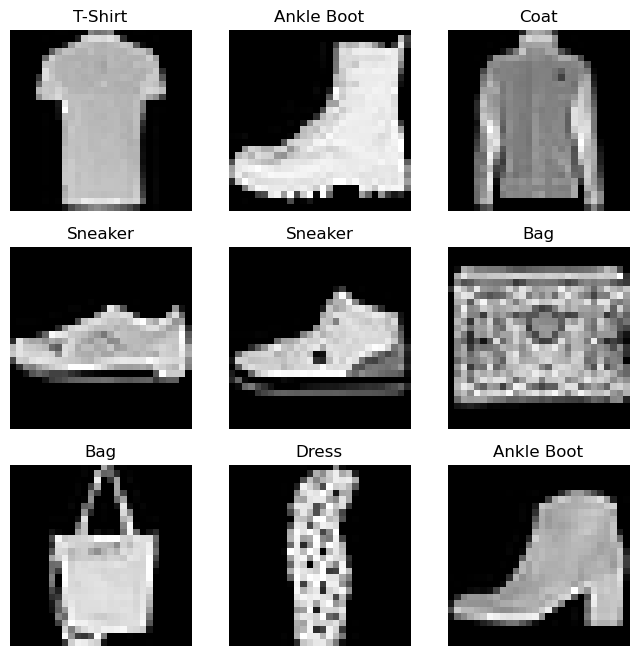

In [9]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Create Dataloaders

<div class="alert alert-block alert-success">
<b>Task:</b> 
We feed the data into our model via Dataloaders. They deal with batching, shuffling etc.
<ul>
<li> Load the training data in the dataloader with a batch size of 64 and shuffle True. Do the same for the test data.
<li> Save them both in a dict object with the keys "train" and "test". The dict object has the name dataloaders. 
</ul>

Hint: Have a look into the PyTorch documentation. <a href="https://pytorch.org/docs/stable/index.html"> Link</a>
</div>

In [10]:
### STUDENT CODE HERE (1pt)

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
dataloaders: dict = {"train":train_dataloader, "test":test_dataloader}

### STUDENT CODE until HERE

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = training_data.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Create Visualization Function
By now, we were just able to randomly show some samples. Here, we create a function that we can use to plot specific samples from our train or test dataset.

In [11]:
def imshow(inp, title=None):
    """Display image for Tensor."""

    # changing from (C,H,W) to (H,W,C)
    inp = inp.numpy().transpose((1, 2, 0))

    inp = np.clip(inp, 0, 1)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    return plt.imshow(inp, cmap="gray")

def visualize_specific_sample(model, sample, data):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        input = data[sample][0]
        label = torch.tensor(data[sample][1])

        input_batched = input[None,:,:,:]
        input_batched = input_batched.to(device)
        label = label.to(device)

        outputs = model(input_batched)
        _, preds = torch.max(outputs, dim=1)

        # iterating over images contained in the batch
        images_so_far += 1
        ax = plt.subplot(1,1,1)
        ax.axis("off")
        ax.set_title(f'predicted: {class_names[preds]}')
        imshow(input.cpu().data)

        model.train(mode=was_training)

## Training Loop

<div class="alert alert-block alert-success">
<b>Task:</b> 
Attention here comes your next task. In the following, you find the training loop. You will complete some parts of it. 
<ol>
<li> Transfer the inputs and labels to our device. This is done with torch.Tensor.to(). Afterwards, zero the gradients.
<li> Make the prediction with the model, get the argmax() of the prediction and calculate the loss by comparing outputs and labels.
<li> Calculate the backward pass and make the optimization step. Make sure that this is happening only during the training stage.
</ol>

Hint: Have a look into the PyTorch documentary.
</div>

In [15]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):

                    # 1. transfer the inputs and labels to the device, before zeroing the gradients here
                    ### STUDENT CODE HERE (1pt)

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    
                    ### STUDENT CODE until HERE

                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):

                        # 2. caluclate the output, the argmax() of the output and the loss here
                        ### STUDENT CODE HERE (2pts)

                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
                        loss = criterion(outputs, labels)

                        ### STUDENT CODE until HERE

                        # 3. Backward pass here and the step. Make sure that this is only happening in the training stage
                        ### STUDENT CODE HERE (1pt)

                        if phase == 'train':
                            loss.backward()  # Backward pass to calculate gradients
                            optimizer.step()  # Update weights

                        ### STUDENT CODE until HERE

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## Hyperparameters and Model adjustments

Here, we are going to set the hyperparameters. This process should be familiar for you. However, additionally, we need to adjust our model. 

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b> The model was pretrained on the imagnet dataset with color images, while we want to adjust it on gray scale images. 
<ul>
<li> What problem occurs? 
<li> There are two approaches to fix this. What are they? 
</div>

<div class="alert alert-block alert-success">
<b>Your Answer:</b> 
<ul>
<li> The model is trained on different number of channels (color -> 3), while gray scale images only have one.
<li> 1) We replicate our gray scale image and feed those same images to each channel of the model. 2) We change the first layer of the model to accept only one channel, by averaging the weights of the channels.
</ul>
</div>

<div class="alert alert-block alert-success">
<b>Task:</b> Hopefully you read this after you answered the questions above. Because for the next part, you need to know what we are going to do and how we decided to solve the problem. We will adjust the first layer of our model, to enable it to process grayscale images with only one channel. 
<ol>
<li> Download the resnet18 model via torchvision.models. Initialize the weights with "IMAGENET1K_V1".
<li> Change the dimension of the first convolutional layer to 1.
<li> Set the weights of the first convolutional layer with torch.nn.Parameter as sum of the weights of the first convolutional layer.  
</ol>

Hint: Use the function torch.sum() and make sure keepdim=True
</div>

In [16]:
### STUDENT CODE HERE (2pt)

model_ft = torchvision.models.resnet18(weights="IMAGENET1K_V1")

original_first_layer = model_ft.conv1

model_ft.conv1 = nn.Conv2d(1, original_first_layer.out_channels, kernel_size=original_first_layer.kernel_size, stride=original_first_layer.stride, padding=original_first_layer.padding)
model_ft.conv1.weight = torch.nn.Parameter(torch.sum(original_first_layer.weight.data, dim=1, keepdim=True))

### STUDENT CODE until HERE

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\asewe/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████| 44.7M/44.7M [00:09<00:00, 4.72MB/s]


<div class="alert alert-block alert-success">
<b>Task:</b> Almost done! Now you are going to chop off the fully connected layer at the end of our model. We are going to train a new new one.
<ol>
<li> Retrieve the in_features of the fully connected layer.
<li> Overwrite the fully connected layer of the model with the desired dimensions.
<li> Send the model over to our device. 
<li> Define a loss function. It should be cross entropy loss.
</ol>

Hint: The input size of the FC has to be the same, as the in_features. 
</div>

In [18]:
### STUDENT CODE HERE (2pt)

in_features = model_ft.fc.in_features

model_ft.fc = torch.nn.Linear(in_features, len(class_names))

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

### STUDENT CODE until HERE

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training

<div class="alert alert-block alert-success">
<b>Task:</b> Set it all together. Call the training function with the correct arguments. Let it run for 25 epochs. Save the model afterwards to your folder "models".
</div>

In [19]:
### STUDENT CODE HERE (1pt)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
model_ft_save_path = "models/trained_resnet18.pth"
torch.save(model_ft.state_dict(), model_ft_save_path)

### STUDENT CODE until HERE

Epoch 0/24
----------


100%|████████████████████████████████████| 938/938 [07:18<00:00,  2.14it/s]


train Loss: 0.4287 Acc: 0.8454


100%|████████████████████████████████████| 157/157 [00:06<00:00, 22.72it/s]


test Loss: 0.3002 Acc: 0.8895
Epoch 1/24
----------


100%|████████████████████████████████████| 938/938 [07:02<00:00,  2.22it/s]


train Loss: 0.2646 Acc: 0.9033


100%|████████████████████████████████████| 157/157 [00:06<00:00, 23.01it/s]


test Loss: 0.2812 Acc: 0.8965
Epoch 2/24
----------


100%|████████████████████████████████████| 938/938 [07:04<00:00,  2.21it/s]


train Loss: 0.2178 Acc: 0.9190


100%|████████████████████████████████████| 157/157 [00:06<00:00, 22.70it/s]


test Loss: 0.2652 Acc: 0.9002
Epoch 3/24
----------


100%|████████████████████████████████████| 938/938 [07:00<00:00,  2.23it/s]


train Loss: 0.1881 Acc: 0.9298


100%|████████████████████████████████████| 157/157 [00:07<00:00, 19.99it/s]


test Loss: 0.2502 Acc: 0.9106
Epoch 4/24
----------


100%|████████████████████████████████████| 938/938 [07:04<00:00,  2.21it/s]


train Loss: 0.1675 Acc: 0.9372


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.22it/s]


test Loss: 0.2565 Acc: 0.9137
Epoch 5/24
----------


100%|████████████████████████████████████| 938/938 [06:49<00:00,  2.29it/s]


train Loss: 0.1513 Acc: 0.9431


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.27it/s]


test Loss: 0.2674 Acc: 0.9073
Epoch 6/24
----------


100%|████████████████████████████████████| 938/938 [06:49<00:00,  2.29it/s]


train Loss: 0.1319 Acc: 0.9511


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.24it/s]


test Loss: 0.2601 Acc: 0.9106
Epoch 7/24
----------


100%|████████████████████████████████████| 938/938 [32:09<00:00,  2.06s/it]


train Loss: 0.0923 Acc: 0.9668


100%|████████████████████████████████████| 157/157 [00:07<00:00, 21.08it/s]


test Loss: 0.2477 Acc: 0.9183
Epoch 8/24
----------


100%|████████████████████████████████████| 938/938 [06:52<00:00,  2.27it/s]


train Loss: 0.0804 Acc: 0.9709


100%|████████████████████████████████████| 157/157 [00:07<00:00, 21.34it/s]


test Loss: 0.2529 Acc: 0.9189
Epoch 9/24
----------


100%|████████████████████████████████████| 938/938 [06:49<00:00,  2.29it/s]


train Loss: 0.0740 Acc: 0.9734


100%|████████████████████████████████████| 157/157 [00:07<00:00, 21.32it/s]


test Loss: 0.2554 Acc: 0.9191
Epoch 10/24
----------


100%|████████████████████████████████████| 938/938 [06:52<00:00,  2.28it/s]


train Loss: 0.0695 Acc: 0.9756


100%|████████████████████████████████████| 157/157 [00:07<00:00, 21.39it/s]


test Loss: 0.2646 Acc: 0.9200
Epoch 11/24
----------


100%|████████████████████████████████████| 938/938 [06:53<00:00,  2.27it/s]


train Loss: 0.0650 Acc: 0.9765


100%|████████████████████████████████████| 157/157 [00:07<00:00, 21.45it/s]


test Loss: 0.2713 Acc: 0.9192
Epoch 12/24
----------


100%|████████████████████████████████████| 938/938 [07:02<00:00,  2.22it/s]


train Loss: 0.0619 Acc: 0.9773


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.00it/s]


test Loss: 0.2720 Acc: 0.9167
Epoch 13/24
----------


100%|████████████████████████████████████| 938/938 [07:28<00:00,  2.09it/s]


train Loss: 0.0588 Acc: 0.9788


100%|████████████████████████████████████| 157/157 [00:07<00:00, 20.16it/s]


test Loss: 0.2734 Acc: 0.9201
Epoch 14/24
----------


100%|████████████████████████████████████| 938/938 [06:49<00:00,  2.29it/s]


train Loss: 0.0534 Acc: 0.9809


100%|████████████████████████████████████| 157/157 [00:07<00:00, 21.98it/s]


test Loss: 0.2738 Acc: 0.9184
Epoch 15/24
----------


100%|████████████████████████████████████| 938/938 [06:46<00:00,  2.31it/s]


train Loss: 0.0523 Acc: 0.9816


100%|████████████████████████████████████| 157/157 [00:07<00:00, 21.95it/s]


test Loss: 0.2737 Acc: 0.9192
Epoch 16/24
----------


100%|████████████████████████████████████| 938/938 [06:46<00:00,  2.31it/s]


train Loss: 0.0538 Acc: 0.9808


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.20it/s]


test Loss: 0.2786 Acc: 0.9193
Epoch 17/24
----------


100%|████████████████████████████████████| 938/938 [06:46<00:00,  2.31it/s]


train Loss: 0.0526 Acc: 0.9816


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.17it/s]


test Loss: 0.2755 Acc: 0.9197
Epoch 18/24
----------


100%|████████████████████████████████████| 938/938 [06:48<00:00,  2.30it/s]


train Loss: 0.0515 Acc: 0.9825


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.06it/s]


test Loss: 0.2724 Acc: 0.9199
Epoch 19/24
----------


100%|████████████████████████████████████| 938/938 [06:47<00:00,  2.30it/s]


train Loss: 0.0527 Acc: 0.9816


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.28it/s]


test Loss: 0.2769 Acc: 0.9178
Epoch 20/24
----------


100%|████████████████████████████████████| 938/938 [06:46<00:00,  2.31it/s]


train Loss: 0.0523 Acc: 0.9822


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.17it/s]


test Loss: 0.2788 Acc: 0.9179
Epoch 21/24
----------


100%|████████████████████████████████████| 938/938 [06:47<00:00,  2.30it/s]


train Loss: 0.0509 Acc: 0.9826


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.24it/s]


test Loss: 0.2808 Acc: 0.9185
Epoch 22/24
----------


100%|████████████████████████████████████| 938/938 [06:47<00:00,  2.30it/s]


train Loss: 0.0509 Acc: 0.9826


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.17it/s]


test Loss: 0.2809 Acc: 0.9189
Epoch 23/24
----------


100%|████████████████████████████████████| 938/938 [06:47<00:00,  2.30it/s]


train Loss: 0.0509 Acc: 0.9825


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.14it/s]


test Loss: 0.2767 Acc: 0.9191
Epoch 24/24
----------


100%|████████████████████████████████████| 938/938 [06:46<00:00,  2.31it/s]


train Loss: 0.0510 Acc: 0.9824


100%|████████████████████████████████████| 157/157 [00:07<00:00, 22.25it/s]


test Loss: 0.2776 Acc: 0.9185
Training complete in 200m 58s
Best test Acc: 0.920100


RuntimeError: Parent directory models does not exist.

## Test your Model 

<div class="alert alert-block alert-success">
<b>Task:</b> Last one! Call the function visualize_specific_sample() on the test data and enjoy the results.
</div>

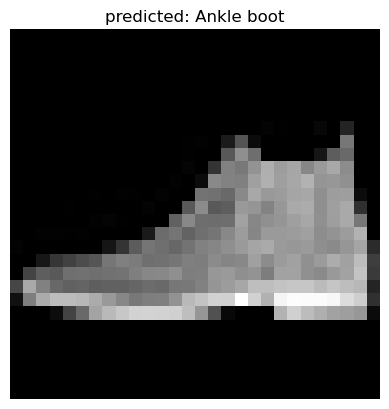

In [20]:
# STUDENT CODE HERE (1pt)

test_images, test_labels = next(iter(test_dataloader))

sample_index = 0
visualize_specific_sample(model_ft, sample_index, test_dataloader.dataset)

# STUDENT CODE until HERE

# Feedback and Recap

<div class="alert alert-block alert-success">
<b>Question (3pt):</b>  Please conclude in a few sentences what you learned in this exercise
</div>

<div class="alert alert-block alert-success">
<b>Your Answer:</b> In this task we downloaded the pretrained resnet18 model, modified its first layer to accept gray-scale images and modified its last layer to output to our number of classes. We trained the modified layers to the zalando fashion dataset and visualized the result.
</div>

## And give us feedback if you like

Subtask 7.3 is completely new designed. Especially here, feedback is very important to improve it. 


1) Do you think this task was designed well? 

2) Where can we improve this task?

<strong>Thanks for participating in LAMA! :)</strong>